<a href="https://colab.research.google.com/github/chanmeee/DL_papers_study/blob/main/%5B%EA%B3%B5%EC%9C%A0%EC%9A%A9%5D%20SimpleGAN_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GAN 논문 구현
- 논문 제목: Ian J. Goodfellow et al. (2014), Generative Adversarial Nets
- 참고자료
  - GAN: Generative Adversarial Networks (꼼꼼한 딥러닝 논문 리뷰와 코드 실습) - https://www.youtube.com/watch?v=AVvlDmhHgC4
  - [Paper Review] Generative Adversarial Networks - https://youtu.be/jB1DxJMUlxY

---
### 들어가며 (Intro)

#### 1) 모델 설명
- GAN에는 다양한 종류가 있으나 논문에서 소개된 가장 기본적인 **SimpleGAN** 을 구현

#### 2) 데이터 설명 
- 논문에서는 MNIST, the Toronto Face Database(TFD), CIFAR-10, 총 3종류의 데이터로 실험을 진행했으며, 이번 구현에서는 MNIST 데이터만 사용함
- PyTorch로 구현한 GAN을 MNIST dataset으로 학습한 후, 학습된 generator이 생성한 가짜 이미지를 확인 

- MNIST 데이터 특징
  - 2차원의 이미지 데이터, **가로 28픽셀 * 세로 28픽셀, 총 784픽셀**의 화소값이 입력되어 있음
  
  <img  src="https://media.vlpt.us/images/a01152a/post/0c9a36cd-0b4e-4210-a9e7-7b16e15deea1/image.png" width=250>

  - 생성모델 $ 𝑃_{gen}$ 이란 각 픽셀 값이 임의의 값을 취했을 때의 동시확률분포(joint probability)를 구하는 것
    - 즉, 각 픽셀이 전부 0이 될 확률이라던가, 전부 1이 될 확률이라던가, 더욱 중간에 가까운 값, 784차원의 모든 값의 분포에 대해서 확률을 구하는 것





### 라이브러리 불러오기 (Importing Libraries)

In [ ]:
import torch
import torch.nn as nn 
import torch.nn.functional as F

from torchvision import datasets 
import torchvision.transforms as transforms
import torchvision.models as models

from torchvision.utils import save_image  # 생성자(Generator)로 생성된 이미지 저장
#from PIL import Image  # 이미지 그리기 
import matplotlib.pyplot as plt
%matplotlib inline

import os
import numpy as np
import time 

### 생성자 및 판별자 모델 정의  (Defining Generator/Discriminator Models)
- `forward` 함수만 정의하게 되면, (변화도를 계산하는) `backward` 함수는 `autograd` 를 사용하여 자동으로 정의됩니다. `forward` 함수에서는 어떠한 Tensor 연산을 사용해도 됩니다.
- [참고] autograd 란
  - 어떤 tensor가 학습에 필요한 tensor라면 backpropagation을 통하여 gradient를 구해야 함. (즉, 미분을 해야 함)
  - autograd는 Tensor의 모든 연산에 대해 자동 미분을 제공
  - PyTorch Gradient 관련 설명 (Autograd) - https://gaussian37.github.io/dl-pytorch-gradient/

In [ ]:
latent_dim = 100  # latent_dim: z(noise)의 차원, 논문에서 100으로 설정함 

# 생성자(Generator) 클래스 정의
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__() 

    # 하나의 블록(block) 정의
    def block(input_dim, output_dim, normalize=True):
      layers = [nn.Linear(input_dim, output_dim)]
      if normalize:
        # 배치 정규화(batch normalization) 수행 (차원 동일)
        layers.append(nn.BatchNorm1d(output_dim, 0.8))  # BatchNorm1d(N, C): N은 배치크기, C는 채널 수
      layers.append(nn.LeakyReLU(0.2, inplace=True))
      return layers

    # 생성자 모델은 연속적인 여러 개의 블록을 가짐
    self.model = nn.Sequential(
        *block(latent_dim, 128, normalize=False),
        *block(128, 256),
        *block(256, 512),
        *block(512, 1024),
        nn.Linear(1024, 1 * 28 * 28),  # 1024: 정사각형 이미지를 flatten 시켰을 때 전체 길이
        nn.Tanh()   # 처음에 MNIST 데이터를 다운로드 받을 때 이미지 픽셀값을 주로 -1~1 사이 값으로 정규화를 시킴. 그래서 정규화시킨 상태와 동일하도록 tanh 함수를 이용해 -1~1 사이의 값으로 출력
    )

  def forward(self, z): 
    img = self.model(z)
    img = img.view(img.size(0), 1, 28, 28)
    return img 

In [ ]:
# 판별자(Discriminator) 클래스 정의
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()

    self.model = nn.Sequential(
        nn.Linear(1 * 28 * 28, 512),  # input_feature=(1 * 28 * 28) - 생성자 모델로 만든 것, output_feature=512 
        nn.LeakyReLU(0.2, inplace=True),
        nn.Linear(512, 256),  # input_feature=512, output_feature=256
        nn.LeakyReLU(0.2, inplace=True),
        nn.Linear(256, 1),  # input_feature=256, 최종 output_feature=1(확률값)
        nn.Sigmoid(),  # 0~1 사이 확률값으로 변환 
    )

  # 이미지에 대한 판별 결과를 반환
  def forward(self, img):
    flattened = img.view(img.size(0), -1)  # 하나의 벡터 형태로 쭉 나열 
    output = self.model(flattened)

    return output 

### 학습 데이터셋 불러오기  (Importing MNIST dataset)
- 학습을 위해 MNIST 데이터셋을 불러옵니다.

In [ ]:
# 배치 사이즈 설정: 하나의 배치에 포함된 이미지 파일의 개수
BATCH_SIZE = 128

# 이미지를 텐서로 변환
transforms_train = transforms.Compose([
    transforms.Resize(28),  # 28로 이미지 크기 변환 
    transforms.ToTensor(),  # 파이토치 텐서로 변환 
    transforms.Normalize([0.5],[0.5]) 
])

train_dataset = datasets.MNIST(root='./dataset', train=True, download=True, # download=True: 인터넷에 있는 데이터를 root로 지정한 위치에 다운로드 받는다
                               transform=transforms_train  # 텐서로 변환
                               )
dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4) # num_workers: 데이터 로드 멀티 프로세싱, 몇 개가 적당한지에 대한 정답은 없으나 GPU 개수 * 4가 좋다는 이야기가 있음

### 모델 학습 및 샘플링  (Modeling)

#### 모델 파라미터 설정

- 학습을 위해 생성자와 판별자 모델을 초기화 → 적절한 하이퍼 파라미터를 설정
- 생성자/판별자 모델, 손실 함수를 계산할 때 GPU 사용
- 생성자/판별자 따로따로 최적화 함수(optimizer) 설정: 각각 `optimizer_G`, `optimizer_D`
---
- 손실 함수(loss function): Binary Cross Entropy 사용
  <img src="https://media.vlpt.us/images/a01152a/post/2532329f-f20e-457d-8b82-dd125c1456b5/image.png">

- 최적화 함수(optimizer): Adam 사용
- 학습률(LR)과 베타 파라미터 값(betas)은 일반적으로 가장 많이 사용하는 값을 사용

In [ ]:
# 생성자(generator)와 판별자(discriminator) 초기화
generator = Generator()
discriminator = Discriminator()

# 손실 함수(loss function)
adversarial_loss = nn.BCELoss()  # BCELoss: Binary Cross Entropy, Real/Fake 구분을 위해 BCELoss 함수로 손실을 계산 

# GPU 사용
generator.cuda()  # .cuda(): GPU 사용 
discriminator.cuda()
adversarial_loss.cuda()

# 학습률(learning rate) 설정
LR = 0.0002

# 생성자와 판별자를 위한 최적화 함수(optimizer)
optimizer_G = torch.optim.Adam(generator.parameters(), lr=LR, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=LR, betas=(0.5, 0.999))

#### 모델 학습

- 모델을 학습하면서 주기적으로 샘플링하여 결과를 확인할 수 있습니다.
- 원래 논문과는 달리 생성자(generator)를 먼저 생성한 뒤, 판별자(discriminator)를 만들었다. 

In [ ]:
N_EPOCHS = 200  # 학습의 횟수(epoch) 설정
SAMPLE_INTERVAL = 2000  # 몇 번의 배치(batch)마다 결과를 출력할 것인지 설정
start_time = time.time()

for epoch in range(N_EPOCHS):
  for i, (imgs, _) in enumerate(dataloader):

    # 진짜(real) 이미지와 가짜(fake) 이미지에 대한 정답 레이블 생성
    real = torch.cuda.FloatTensor(imgs.size(0), 1).fill_(1.0)  # 진짜(real): 1  ##imgs.size(0): 매 배치에 포함된 이미지 개수, 이만큼의 진짜 이미지와 가짜 이미지를 생성
    fake = torch.cuda.FloatTensor(imgs.size(0), 1).fill_(0.0)  # 가짜(fake): 0

    real_imgs = imgs.cuda()

    """ 생성자(generator)를 학습합니다 """
    optimizer_G.zero_grad()

    # 랜덤 노이즈(noise) 샘플링
    z = torch.normal(mean=0, std=1, size=(imgs.shape[0], latent_dim)).cuda()

    # 이미지 생성
    generated_imgs = generator(z)

    # 생성자(generator)의 손실(loss) 값 계산
    g_loss = adversarial_loss(discriminator(generated_imgs), real) ## 생성자 입장에서는 자신이 만든 이미지가 real 이미지로 분류될 수 있도록, 즉 1에 가깝도록 해야 함, 따라서 그런 방향으로 손실 값 계산하여 학습을 진행함.

    # 생성자(generator) 업데이트
    g_loss.backward()  # 역전파(back-propagation), 역전파 시작할 지점의 output은 scalar 형태이어야 함 
    optimizer_G.step()

    """ 판별자(discriminator)를 학습합니다 """
    optimizer_D.zero_grad()

    # 판별자(discriminator)의 손실(loss) 값 계산
    real_loss = adversarial_loss(discriminator(real_imgs), real) ## 판별자 입장에서는 실제 이미지를 받았을 때 real 이미지로 분류될 수 있도록, 손실 값(real_loss) 계산하여 학습을 진행함.
    fake_loss = adversarial_loss(discriminator(generated_imgs.detach()), fake)  ## 더불어 판별자 입장에서는 앞서 생성자로 생성한 이미지가 fake 이미지로 분류될 수 있도록, 즉 0에 가깝도록 손실 값(fake_loss) 계산하여 학습을 진행함.
    d_loss = (real_loss + fake_loss) / 2  # 2개의 손실함수를 이용하여, 즉 (진짜 이미지에 대한 Loss)와 (가짜 이미지에 대한 Loss) 를 구해서 평균을 구하고, backward 해줌

    # 판별자(discriminator) 업데이트
    d_loss.backward()  # 역전파(back-propagation)
    optimizer_D.step() 

    done = epoch * len(dataloader) + i
    if done % SAMPLE_INTERVAL == 0:
      # 생성된 이미지들 중에서 25개만 선택하여 5x5 격자 이미지에 출력
      save_image(generated_imgs.data[:25], f"{done}.png", nrow=5, normalize=True)

  # 10번의 epoch가 끝날 때마다 로그(log) 출력
  if epoch % 10 == 0:
    print(f"[Epoch {epoch}/{N_EPOCHS}] [D loss: {d_loss.item():.6f}] [G loss: {g_loss.item():.6f}] [Elapsed time: {time.time() - start_time:.2f}s]")

[Epoch 0/200] [D loss: 0.070347] [G loss: 4.178710] [Elapsed time: 8.04s]
[Epoch 10/200] [D loss: 0.072106] [G loss: 4.653742] [Elapsed time: 88.31s]
[Epoch 20/200] [D loss: 0.240200] [G loss: 5.408567] [Elapsed time: 168.33s]
[Epoch 30/200] [D loss: 0.258584] [G loss: 4.726148] [Elapsed time: 247.86s]
[Epoch 40/200] [D loss: 0.066357] [G loss: 4.168776] [Elapsed time: 327.34s]
[Epoch 50/200] [D loss: 0.103986] [G loss: 2.961840] [Elapsed time: 407.08s]
[Epoch 60/200] [D loss: 0.162235] [G loss: 4.168613] [Elapsed time: 486.50s]
[Epoch 70/200] [D loss: 0.224956] [G loss: 1.854720] [Elapsed time: 565.85s]
[Epoch 80/200] [D loss: 0.182802] [G loss: 5.545515] [Elapsed time: 645.14s]
[Epoch 90/200] [D loss: 0.238679] [G loss: 3.002261] [Elapsed time: 724.34s]
[Epoch 100/200] [D loss: 0.118530] [G loss: 2.704339] [Elapsed time: 803.29s]
[Epoch 110/200] [D loss: 0.166872] [G loss: 5.569143] [Elapsed time: 882.64s]
[Epoch 120/200] [D loss: 0.161427] [G loss: 3.535645] [Elapsed time: 961.06s]


### 생성된 이미지 예시 출력 (Printing a generated image)

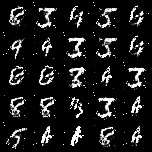

In [ ]:
from IPython.display import Image
Image('92000.png')

- 생성된 이미지를 살펴보면, 8/3/4/5/8/.. 이런 식으로 숫자들이 생성된 것을 알 수 있다.
- 0~9 중 어느 숫자로도 보기 난해한 경우가 일부 생성되기도 하였으나, 전반적으로 실제 손글씨 숫자데이터와 비슷한 이미지가 만들어졌다.

-- 끝. --